In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import Imputer
from astropy.io import fits
import urllib2, re
from matplotlib.pyplot import subplots
import functools
import multiprocessing
import thread
import Queue
import time
import random
from scipy.stats import linregress, kurtosis
import copy
from itertools import izip, imap
import sys
import warnings
print sys.version

import matplotlib as mpl
from k2utils import *
from vj_processing import *

2.7.14 |Anaconda custom (64-bit)| (default, Oct 16 2017, 17:29:19) 
[GCC 7.2.0]


In [58]:
ccd = CCD(module=6, channel=2, campaign=8, field='FLUX')
objects = searchProposal('GO', 8)
objects = dict(filter(moduleFilter(ccd), objects.items()))
def quick_view(EPIC):
    url = get_vj_url(EPIC, 8)
    hdu = next(fits_downloader([url]))
    fig, ax = subplots(1,1)
    plotNiceIntervals(ax, hdu[1].data['T'], hdu[1].data['FRAW'], label='EPIC %i' % EPIC, N=60)
    ax.legend()
    m = np.nanmean(hdu[1].data['FRAW'])
    s = np.nanstd(hdu[1].data['FRAW'])
    ax.set_ylim(m-2*s, m+2*s)
    print EPIC
    
def quick_views(*EPICS):
    for epic in EPICS:
        quick_view(epic)

def get_lcs(*EPICS):
    
    return map(get_lc, EPICS)
        
def get_lc(EPIC):
    url = get_vj_url(EPIC, 8)
    hdu = next(fits_downloader([url]))
    return map(np.array, (hdu[1].data['T'], hdu[1].data['FCOR']))

In [101]:
sorted_objs = sorted(objects.items(), key=lambda x: -x[1][0])
faint = [ i for i in sorted_objs[:30] if i[0] in [220289355, 220284690, 220252978]]
faint = sorted_objs[:]
#quick_views(*dict(faint).keys())
ts_, lcs_ = zip(*get_lcs(*dict(faint).keys()))

(3451, 124)
(3451, 3)
(3, 124)
7.91407893532e-18 0.0170226637412
1.02947368264e-18 0.0170226637412
-4.18223683574e-19 0.0170226637412


(-0.005, 0.005)

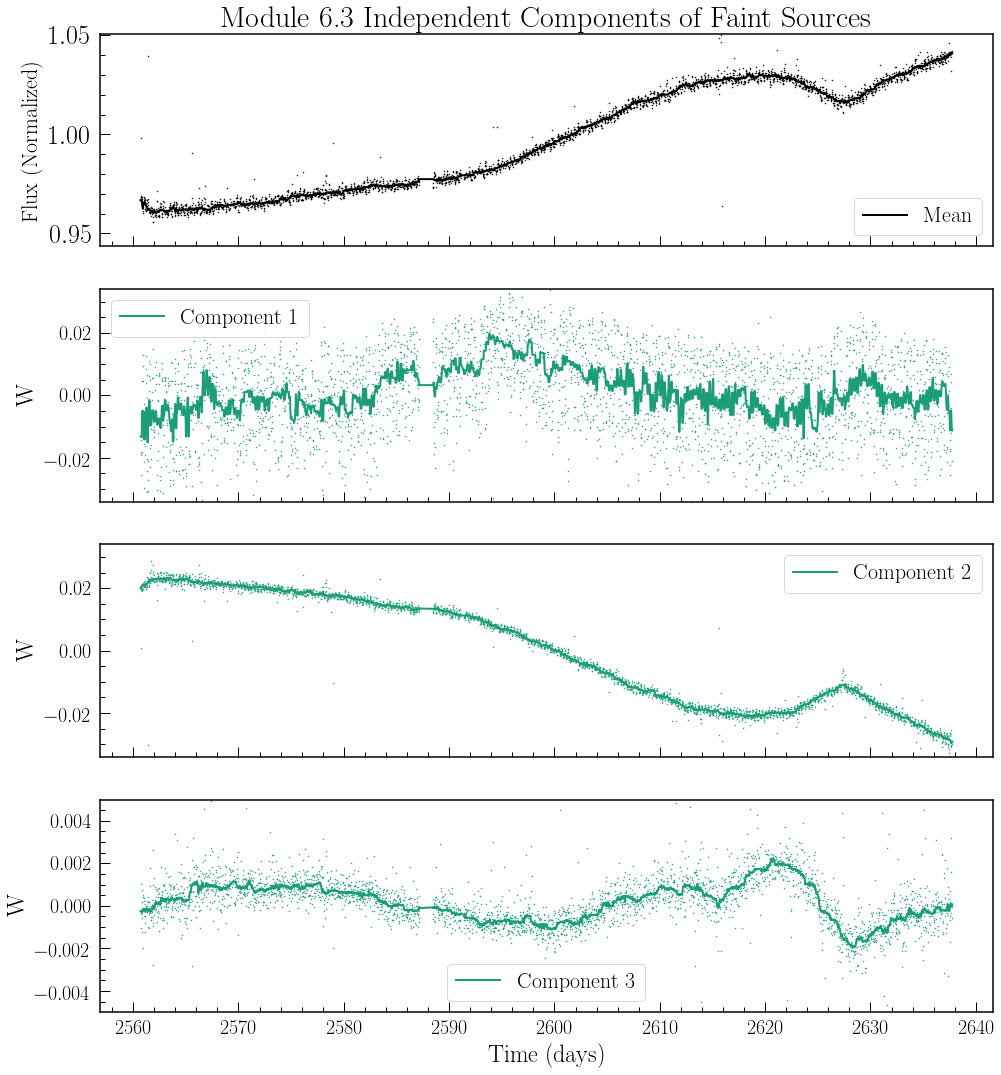

In [103]:

ts = np.array([t for t in ts_ if len(t) == 3451])
lcs = np.array([l for l in lcs_ if len(l) == 3451]).T
#print map(len, lcs)

ncomp = 4


#meanLC = lcs.mean(1)
meanLC = np.nanmean(lcs, axis=1)

ica = FastICA(ncomp - 1)
imp = Imputer(missing_values='NaN', strategy='median', axis=0) # Use an imputer to handle NaNs
imp.fit(lcs)

trans= imp.transform(lcs)
print trans.shape
X = ica.fit_transform(imp.transform(lcs))
print X.shape
weights = ica.components_
print weights.shape
fig, ax = subplots(ncomp,1, figsize=(16,9*ncomp/2), sharex=True)
plotNiceIntervals(ax[0],ts[0],meanLC,N=30, label='Mean', color='k')
m = np.nanmean(meanLC)
s = np.nanstd(meanLC)
ax[0].set_ylim(m-2*s, m+2*s)
ax[0].set_title('Module 6.3 Independent Components of Faint Sources')
ax[0].legend()
ax[0].set_ylabel('Flux (Normalized)', fontsize=24)
for i,a in enumerate(ax.flat):
    if i > 0:
        plotNiceIntervals(a,ts[0],X[:,i-1],N=30, label='Component %i' % (i), color=rplot.csdark[0])
        a.legend(prop={'size':22})
        a.xaxis.label.set_size(22)
        a.yaxis.label.set_size(22)
        a.tick_params(axis='both', which='major', labelsize=20)
        a.title.set_size(24)
        arr = np.array(X[:, i-1])
        m = np.nanmean(X[:,i-1])
        s = np.nanstd(X[:,i-1])
        a.set_ylabel('W', fontsize=24)
        print m, s
        a.set_ylim(m-2*s, m+2*s)
ax[0].legend(prop={'size':22})   
ax[0].xaxis.label.set_size(22)
ax[0].yaxis.label.set_size(22)
ax[0].tick_params(axis='both', which='major', labelsize=26)
ax[0].title.set_size(30)
ax[-1].set_xlabel('Time (days)', fontsize=24)
ax[-1].set_ylim(-0.005, 0.005)